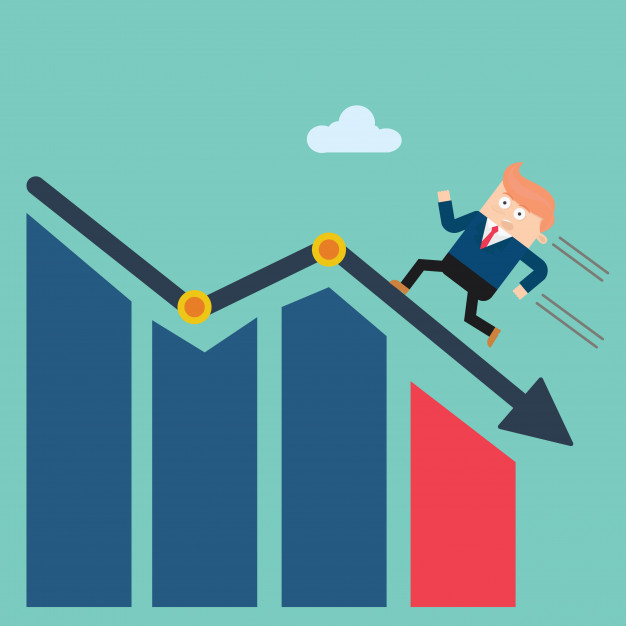

<font size="+3" color='#053c96'><b> Introduction</b></font>



Time series analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. Time series forecasting is the use of a model to predict future values based on previously observed values.Whether we wish to predict the trend in financial markets or electricity consumption, time is an important factor that must now be considered in our models. For example, it would be interesting to forecast at what hour during the day is there going to be a peak consumption in electricity, such as to adjust the price or the production of electricity.


<font size="+3" color='#053c96'><b> About Dataset</b></font>

The dataset used is stock market data of the Nifty-50 index from NSE (National Stock Exchange) India over the last 20 years (2000 - 2019)

The historic VWAP (Volume Weighted Average Price) is the target variable to predict. VWAP is a trading benchmark used by traders that gives the average price the stock has traded at throughout the day, based on both volume and price.
Read more about the dataset: https://www.kaggle.com/rohanrao/nifty50-stock-market-data

I am using Reliance stock prices .

Inspired from -

* https://www.kaggle.com/parulpandey/getting-started-with-time-series-using-pandas
* https://www.kaggle.com/rohanrao/a-modern-time-series-tutorial

<font size="+3" color='#053c96'><b> Reliance Industries Limited </b></font>

Reliance Industries Limited (RIL) is an Indian multinational conglomerate company headquartered in Mumbai, Maharashtra, India. Reliance owns businesses across India engaged in energy, petrochemicals, textiles, natural resources, retail, and telecommunications. Reliance is one of the most profitable companies in India,the largest publicly traded company in India by market capitalization,and the largest company in India as measured by revenue after recently surpassing the government-controlled Indian Oil Corporation.On 22 June 2020, Reliance Industries became the first Indian company to exceed US$150 billion in market capitalization after its market capitalization hit ₹11,43,667 crore on the BSE.
The company is ranked 96th on the Fortune Global 500 list of the world's biggest corporations as of 2020.It is ranked 8th among the Top 250 Global Energy Companies by Platts as of 2016. Reliance continues to be India's largest exporter, accounting for 8% of India's total merchandise exports with a value of ₹1,47,755 crore and access to markets in 108 countries.Reliance is responsible for almost 5% of the government of India's total revenues from customs and excise duty. It is also the highest income tax payer in the private sector in India.

~ *Source - wikipedia*

## This notebook will the cover - 

* Data Preparation
* Exploratory Data Analysis
* Feature Engineering 
* AUTO-ARIMA Model
* Analyzing residuals 
* Evaluating Model 

<font size="+3" color='#780404'><b> Data Preparation </b></font>

## Import Libraries

In [ ]:
!pip install pmdarima

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates
import scipy.stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pylab
sns.set(style='white')
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose


## Import dataset

In [ ]:
df=pd.read_csv('../input/nifty50-stock-market-data/RELIANCE.csv')

## Converting Date into DateTime format 

In [ ]:
df['Date']=pd.to_datetime(df['Date'])
df.set_index(['Date'],inplace=True)

In [ ]:
df.head()

## data summary

In [ ]:
df.describe()

In [ ]:
df.shape

## Check for missing values

In [ ]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
missing_table=missing_values_table(df)
missing_table

* There are missing vales in Trades , Deliverable Volumne and % deliverable

## Visualizing the locations of the missing data

In [ ]:
msno.matrix(df)

* As you can see all the starting values are missing in columns Trades , Deliverable Volume	 and %Deliverble

## Handling missing values 

In [ ]:
df.Trades.plot()

In [ ]:
df.Trades[:2850]

* we don't have data of Trades on and before 31-05-2011 

In [ ]:
# removing missing columns

df.drop(['Trades','Deliverable Volume','%Deliverble'],axis=1,inplace=True)


<font size="+3" color='#780404'><b>Exploratory Data Analysis</b></font>

## Plotting VWAP(Volume Weighted Average Price) over time

In [ ]:
fig = go.Figure([go.Scatter(x=df.index, y=df['VWAP'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    title='VWAP over time',
    template="simple_white",
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="VWAP")
fig.show()

* There is steady increase in prices upto year 2008 
* Stock price fell after jan 2008  and attain pick again in may-june 2009  after that it fell again .

 ## Visualising using KDEs
 Summarizing the data with Density plots to see where the mass of the data is located

In [ ]:
sns.kdeplot(df['VWAP'],shade=True)

* There are two picks in VWAP prices

## VWAP in 2019

In [ ]:
fig = go.Figure([go.Scatter(x=df.loc['2019', 'VWAP'].index,y=df.loc['2020', 'VWAP'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    title='VWAP in 2019',
    template="simple_white",
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="VWAP")

fig.show()

* There was many dips in year 2019 like in May-June , Aug-Sept and in end of the Sept month 

## VWAP in 2020

In [ ]:
fig = go.Figure([go.Scatter(x=df.loc['2020', 'VWAP'].index,y=df.loc['2020', 'VWAP'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    title='VWAP in 2020',
    template="simple_white",
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="VWAP")
fig.show()

* as you can see there is deep in the month of march and april.
* Steady increase after month of april .

## Open,close,High,low prices over time 

In [ ]:
cols_plot = ['Open', 'Close', 'High','Low']
axes = df[cols_plot].plot(figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

* All are following same pattern 

## Volume over Time 

In [ ]:
fig = go.Figure([go.Scatter(x=df.index, y=df['Volume'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    template='simple_white',
    title='Volume over time'
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="Volume")
fig.show()

## Volume in 2020

In [ ]:
fig = go.Figure([go.Scatter(x=df.loc['2020', 'Volume'].index,y=df.loc['2020', 'Volume'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    template='simple_white',
    title='Volume in 2020'
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="Volume")
fig.show()

## Q-Q plot of VWAP 

used to determine whether dataset is distributed a certain way 

In [ ]:
scipy.stats.probplot(df.VWAP,plot=pylab)
pylab.show()

* data is not normally distributed , however this is what we usually expect from timeseries 

## Stationarity 

In the most intuitive sense, stationarity means that the statistical properties of a process generating a time series do not change over time. It does not mean that the series does not change over time, just that the way it changes does not itself change over time. The algebraic equivalent is thus a linear function, perhaps, and not a constant one; the value of a linear function changes as 𝒙 grows, but the way it changes remains constant — it has a constant slope; one value that captures that rate of change.

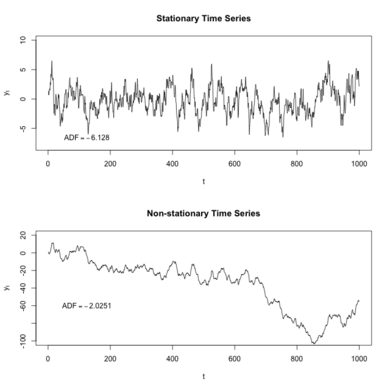

Formally, the process {xᵢ ; i∈ℤ} is weakly stationary if:
1. The first moment of xᵢ is constant; i.e. ∀t, E[xᵢ]=𝜇
2. The second moment of xᵢ is finite for all t; i.e. ∀t, E[xᵢ²]<∞ (which also implies of course E[(xᵢ-𝜇)²]<∞; i.e. that variance is finite for all t)
3. The cross moment — i.e. the auto-covariance — depends only on the difference u-v; i.e. ∀u,v,a, cov(xᵤ, xᵥ)=cov(xᵤ₊ₐ, xᵥ₊ₐ)

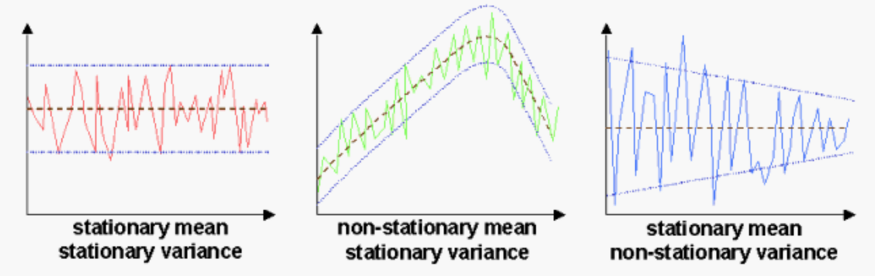

> Note - If you want to know more about stationarity , you can refer this [link](http://https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322#:~:text=In%20the%20most%20intuitive%20sense,not%20itself%20change%20over%20time.)

## Check Stationarity i.e Dicky Fuller Test

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend
It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

**Null Hypothesis (H0)**: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

**Alternate Hypothesis (H1)**: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [ ]:
def dicky_fuller_test(x):
    result = adfuller(x)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1]>0.05:
        print("Fail to reject the null hypothesis (H0), the data is non-stationary")
    else:
        print("Reject the null hypothesis (H0), the data is stationary.")

In [ ]:
dicky_fuller_test(df['VWAP'])

## Seasonal Decompose

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

plt.rcParams.update({'figure.figsize': (10,10)})
y = df['VWAP'].to_frame()


# Multiplicative Decomposition 
result_mul = seasonal_decompose(y, model='multiplicative',period = 52)

# Additive Decomposition
result_add = seasonal_decompose(y, model='additive',period = 52)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

* cyclic patter is shown in every 30 days (monthly)

## Convert Stationary into Non Stationary

### Differencing

In [ ]:
df['vwap_diff']=df['VWAP']-df['VWAP'].shift(1)

In [ ]:
fig = go.Figure([go.Scatter(x=df.index,y=df.VWAP)])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    template='simple_white',
    title='VWAP over time ')
fig.show()

In [ ]:
fig = go.Figure([go.Scatter(x=df.index,y=df.vwap_diff)])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    template='simple_white',
    title='difference VWAP over time ')
fig.show()

* We don't actually need to convert the time series data into stationary data. For study purpose,I have explained how to check stationarity and how to convert non-stationary data into stationary data 

## Plotting ACF and PACF 

**Autocorrelation** and **partial autocorrelation** plots are heavily used in time series analysis and forecasting.

These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps.

**Statistical correlation** summarizes the strength of the relationship between two variables.

We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a **serial correlation, or an autocorrelation.**

A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. This plot is sometimes called a **correlogram or an autocorrelation plot**.

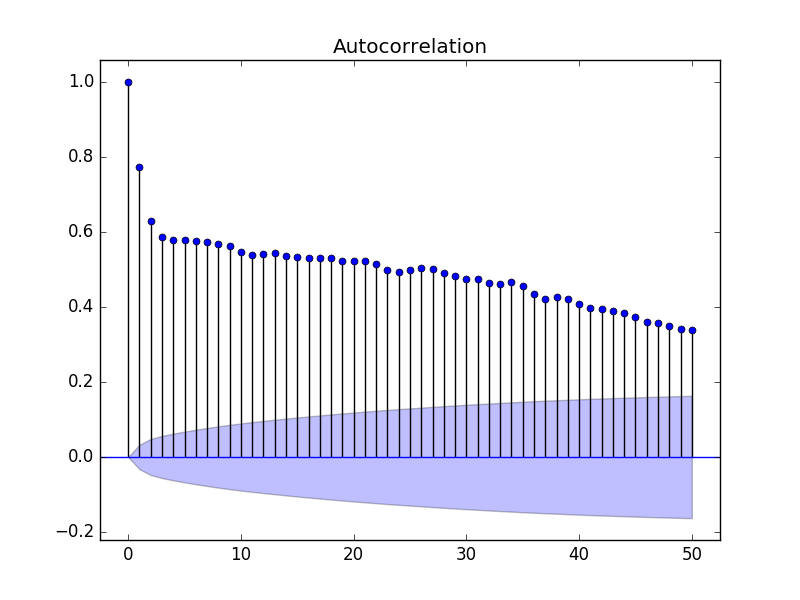


A **partial autocorrelation** is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The autocorrelation for an observation and an observation at a prior time step is comprised of both the direct correlation and indirect correlations. These indirect correlations are a linear function of the correlation of the observation, with observations at intervening time steps.

It is these indirect correlations that the partial autocorrelation function seeks to remove. Without going into the math, this is the intuition for the partial autocorrelation.

A **partial autocorrelation** is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The autocorrelation for an observation and an observation at a prior time step is comprised of both the direct correlation and indirect correlations. These indirect correlations are a linear function of the correlation of the observation, with observations at intervening time steps.

It is these indirect correlations that the partial autocorrelation function seeks to remove. Without going into the math, this is the intuition for the partial autocorrelation.

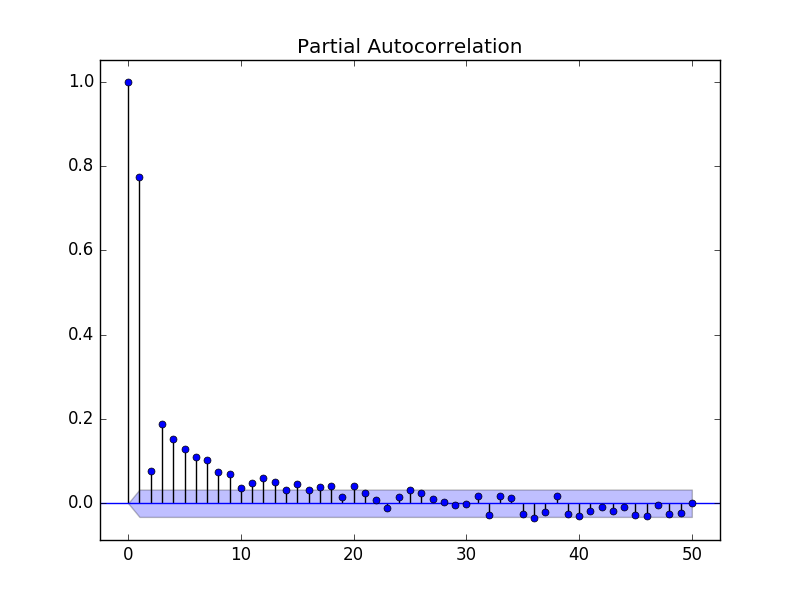

In [ ]:
sm.graphics.tsa.plot_acf(df['VWAP'].iloc[1:], lags=40,title='auto correlation of VWAP',zero=False)
plt.show()

In [ ]:
sm.graphics.tsa.plot_acf(df['vwap_diff'].iloc[7:], lags=40,title='auto correlation of difference VWAP',zero=False)
plt.show()

In [ ]:
sm.graphics.tsa.plot_pacf(df['VWAP'].iloc[1:], lags=40,title='partial auto correlation of VWAP',zero=False)
plt.show()

In [ ]:
sm.graphics.tsa.plot_pacf(df['vwap_diff'].iloc[1:], lags=40,title='partial autocorrelation of difference VWAP  ',zero=False)
plt.show()

<font size="+3" color='#780404'><b> Feature Engineering </b></font>

Adding lag values of High, Low, Volume,Turnover, will use three sets of lagged values, one previous day, one looking back 7 days and another looking back 30 days as a proxy for last week and last month metrics.

In [ ]:
df.head()

In [ ]:
df=df.reset_index()

In [ ]:
lag_features = ["High", "Low", "Volume", "Turnover","Close"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("Date", drop=False, inplace=True)

In [ ]:

df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")
df["month"] = df.Date.dt.month
df["week"] = df.Date.dt.week
df["day"] = df.Date.dt.day
df["day_of_week"] = df.Date.dt.dayofweek


In [ ]:
df.head()

In [ ]:

df_train = df[df.Date < "2019"]
df_valid = df[df.Date >= "2019"]

exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3",
                      "Volume_mean_lag3", "Volume_std_lag3", "Turnover_mean_lag3",
                      "Turnover_std_lag3","High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7",
                      "Volume_mean_lag7", "Volume_std_lag7", "Turnover_mean_lag7",
                      "Turnover_std_lag7","High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30",
                      "Volume_mean_lag30", "Volume_std_lag30", "Turnover_mean_lag30",
                      "Close_mean_lag3", "Close_mean_lag7","Close_mean_lag30","Close_std_lag3","Close_std_lag7","Close_std_lag30",
                      "Turnover_std_lag30","month","week","day","day_of_week"]


<font size="+3" color='#780404'><b> AUTO-ARIMA Model </b></font>

In [ ]:
model = auto_arima(df_train.VWAP, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.VWAP, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

In [ ]:
model.summary()

In [ ]:
df_valid[["VWAP", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

<font size="+3" color='#780404'><b> Analyzing residuals </b></font>

In [ ]:
residuals=df_valid.VWAP-df_valid.Forecast_ARIMAX

In [ ]:
dicky_fuller_test((residuals))

In [ ]:
residuals.plot()

<font size="+3" color='#780404'><b> Evaluating Model </b></font>

In [ ]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))

<font size="+1" color='#9b24a3'><b>I hope you enjoyed this kernel , Please don't forget to appreciate me with an Upvote.</b></font>

<img src="https://i.pinimg.com/originals/e2/d7/c7/e2d7c71b09ae9041c310cb6b2e2918da.gif">